# Sensor Modeling

# This tutorial demonstrates how to model sensor geometries.

## Setup

In [1]:
import sys

! {sys.executable} -m pip install --quiet numpy --upgrade
! {sys.executable} -m pip install --quiet plotly

# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryCorePy==0.1.9
# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryMathematicsPy==0.1.5
# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryPhysicsPy==0.1.3

In [1]:
import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [2]:
import Library.Core as Core
import Library.Mathematics as Mathematics
import Library.Physics as Physics
import Library.Astrodynamics as Astrodynamics

In [3]:
Object2 = Mathematics.Geometry.D2.Object
Point2 = Mathematics.Geometry.D2.Objects.Point
Polygon2 = Mathematics.Geometry.D2.Objects.Polygon
Point3 = Mathematics.Geometry.D3.Objects.Point
Polygon3 = Mathematics.Geometry.D3.Objects.Polygon
Ellipsoid = Mathematics.Geometry.D3.Objects.Ellipsoid
Pyramid = Mathematics.Geometry.D3.Objects.Pyramid

Length = Physics.Units.Length
Angle = Physics.Units.Angle
Scale = Physics.Time.Scale
Instant = Physics.Time.Instant
Duration = Physics.Time.Duration
Interval = Physics.Time.Interval
DateTime = Physics.Time.DateTime
LLA = Physics.Coordinate.Spherical.LLA
Position = Physics.Coordinate.Position
Frame = Physics.Coordinate.Frame
Environment = Physics.Environment
Geometry = Physics.Environment.Object.Geometry
Earth = Physics.Environment.Objects.CelestialBodies.Earth

Trajectory = Astrodynamics.Trajectory
Orbit = Astrodynamics.Trajectory.Orbit
Access = Astrodynamics.Access

---

## Computation

### Environment

In [4]:
environment = Environment.Default() ;

In [5]:
earth = environment.accessCelestialObjectWithName("Earth")

In [6]:
earth_geometry = earth.getGeometryIn(Frame.ITRF())

### Satellite

Let's define the orbit of a satellite in LEO. In this example, we're modeling the orbit using SGP4.

First, we need a **Two-Line Element** (TLE) set:

In [7]:
tle = Orbit.Models.SGP4.TLE("1 25544U 98067A   18231.17878740  .00000187  00000-0  10196-4 0  9994",
                            "2 25544  51.6447  64.7824 0005971  73.1467  36.4366 15.53848234128316")

To setup a **SGP4** orbital model:

In [8]:
orbital_model = Orbit.Models.SGP4(tle)

We then obtain the satellite orbit (which is a trajectory):

In [9]:
satellite_orbit = Orbit(orbital_model, earth)

In [10]:
start_instant = Instant.DateTime(DateTime(2018, 1, 1, 0, 0, 0), Scale.UTC) ;
end_instant = Instant.DateTime(DateTime(2018, 1, 1, 0, 0, 1), Scale.UTC) ;

interval = Interval.Closed(start_instant, end_instant) ;

In [11]:
step = Duration.Minutes(1.0)

In [12]:
instants = interval.generateGrid(step)

In [13]:
states = [[instant, satellite_orbit.getStateAt(instant)] for instant in instants]

### Sensor

In [28]:
ned_frame = satellite_orbit.getOrbitalFrame(Orbit.FrameType.NED)

In [29]:
ned_frame

-- Frame -------------------------------------------------------------------------------------------
    Name:                                    Orbit [NED]                              
    Quasi-inertial:                          false                                    
----------------------------------------------------------------------------------------------------

In [30]:
def calculate_intersection (state, frame, sensor):
    
    observer_geometry = Geometry(sensor, frame)
    
    intersection_ITRF = observer_geometry.intersectionWith(earth_geometry)
    
    return intersection_ITRF

In [31]:
apex = Point3(7000e3, 0.0, 0.0)
base = Polygon3(Polygon2([Point2(-1.0, -1.0), Point2(+1.0, -1.0), Point2(+1.0, +1.0), Point2(-1.0, +1.0)]), apex - np.array((0.8, 0.0, 0.0)), np.array((0.0, 1.0, 0.0)), np.array((0.0, 0.0, 1.0)))

pyramid = Pyramid(base, apex)

In [33]:
intersections_ITRF = [calculate_intersection(state, ned_frame, pyramid) for state in states]

RuntimeError: Only same frame intersection supported at the moment.

In [ ]:
intersections_ITRF

In [17]:
intersection_ITRF = observer_geometry.intersectionWith(earth_geometry)

In [18]:
intersection_points = [Point2(lla.getLongitude().inDegrees(), lla.getLatitude().inDegrees()) for lla in [LLA.Cartesian(point_ITRF, Earth.EquatorialRadius, Earth.Flattening) for point_ITRF in intersection_ITRF.asLineString()]]

In [19]:
intersection_polygon = Polygon2(intersection_points)

In [20]:
intersection_df = pd.DataFrame([[intersection_point.x(), intersection_point.y()] for intersection_point in intersection_points], columns=['Longitude', 'Latitude']) ;

In [21]:
intersection_df.head()

,Longitude,Latitude
0,-8.768124,-8.724736
1,-8.152094,-5.915820
2,-7.861145,-3.893102
3,-7.713093,-2.226168
4,-7.649121,-0.725558


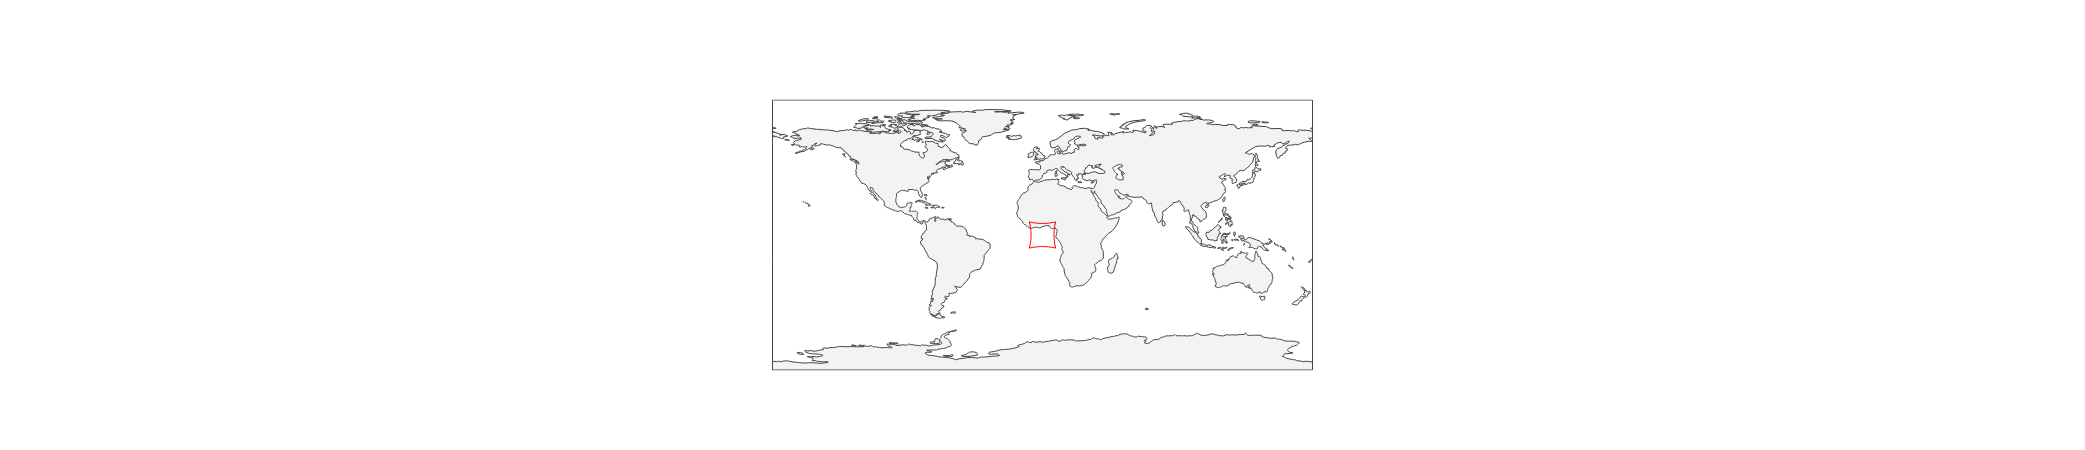

In [22]:
data = []

data.append(
    dict(
        type = 'scattergeo',
        lon = intersection_df['Longitude'],
        lat = intersection_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 1,
            color = 'red',
        )
    )
)
    
layout = dict(
        title = None,
        showlegend = False, 
        geo = dict(
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
fig = dict(data=data, layout=layout)
iplot(fig)